Imports

In [6]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Convenience function for adding row and column headers to a multiplot

In [7]:
# source: https://stackoverflow.com/a/71887460

def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs
):
    # Based on https://stackoverflow.com/a/25814386

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )

Load the synthetic data

In [8]:
df_synthetic = pd.read_csv("./data/synthetic.csv")
df_synthetic = df_synthetic[["Tb.BV/TV", "Tb.N", "Tb.Sp", "Tb.Th"]].copy()
df_synthetic["source"] = "Synthetic"
df_synthetic["dx"] = 1
df_synthetic

,Tb.BV/TV,Tb.N,Tb.Sp,Tb.Th,source,dx
0,1.96,0.057017,17.538759,2.000000,Synthetic,1
1,33.28,0.029849,17.246748,14.000000,Synthetic,1
2,25.84,0.036945,15.167651,9.126035,Synthetic,1
3,62.92,0.043463,6.494861,14.000000,Synthetic,1
4,25.92,0.075912,8.355190,6.000000,Synthetic,1
...,...,...,...,...,...,...
139,8.00,0.040239,20.794783,6.000000,Synthetic,1
140,21.97,0.052535,12.995443,7.000000,Synthetic,1
141,44.89,0.499864,2.000000,2.000891,Synthetic,1
142,0.64,0.030472,32.817257,2.000000,Synthetic,1


Load the in vivo data

In [9]:
data_fn = "./data/NORMXTII_CALGARY_ANALYSIS.csv"
df_normxtii = pd.read_csv(data_fn, skiprows=[0,2])

data_fn = "./data/HIPFX_CALGARY_ANALYSIS.csv"
df_hipfx = pd.read_csv(data_fn, skiprows=[0,2])

data_fn = "./data/Calgary_Analysis_NOREG_March2021.xlsx"
df_fsk = pd.read_excel(data_fn, skiprows=[0,2])

data_fn = "./data/Results_CSI_CalgaryAnalysis_NoReg.xlsx"
df_csi = pd.read_excel(data_fn, skiprows=[0,2])

df_invivo = pd.concat([df_normxtii, df_hipfx, df_fsk, df_csi])
df_invivo.reset_index(inplace=True)

df_invivo = df_invivo[["BVTV", "TbN", "TbSp", "TbTh", "ConnD", "SMI", "Tb1NSD", "DA"]]
df_invivo.rename(columns={
    "BVTV": "Tb.BV/TV",
    "TbN": "Tb.N",
    "TbSp": "Tb.Sp",
    "TbTh": "Tb.Th",
    "ConnD": "Conn.D",
    "Tb1NSD": "Tb.1/N.SD"
}, inplace=True)
df_invivo["source"] = "Measured"
df_invivo["dx"] = 0.0607
df_invivo

,Tb.BV/TV,Tb.N,Tb.Sp,Tb.Th,Conn.D,SMI,Tb.1/N.SD,DA,source,dx
0,18.03,1.471072,0.654324,0.211658,2.7382,3.1483,0.241152,1.4430,Measured,0.0607
1,21.01,1.377651,0.692928,0.221086,3.1940,1.9017,0.239446,1.5271,Measured,0.0607
2,17.35,1.062611,0.918462,0.231946,1.8412,2.2554,0.386104,1.4290,Measured,0.0607
3,20.79,1.017602,0.970389,0.245244,2.1040,1.2481,0.466018,1.5065,Measured,0.0607
4,19.53,1.406310,0.688509,0.223019,2.8326,4.3919,0.249704,1.4063,Measured,0.0607
...,...,...,...,...,...,...,...,...,...,...
3147,31.47,1.646634,0.529509,0.231167,4.0874,0.8506,0.188939,1.7229,Measured,0.0607
3148,35.73,1.525534,0.609297,0.296350,2.7817,0.1693,0.264256,1.7512,Measured,0.0607
3149,36.36,1.431097,0.651621,0.308975,2.1990,-0.2502,0.279018,1.7602,Measured,0.0607
3150,17.86,1.345942,0.723328,0.227161,2.1319,3.9000,0.264900,1.3158,Measured,0.0607


Create the "Dependent" generated data for supplemental analysis

In [10]:
df_dependent = df_invivo.copy()
df_dependent["Tb.N"] = 1 / (df_dependent["Tb.Th"] + df_dependent["Tb.Sp"])
df_dependent["Tb.BV/TV"] = 100 * np.pi/2 * ( df_dependent["Tb.Th"] / (df_dependent["Tb.Th"] + df_dependent["Tb.Sp"]) )**2
df_dependent["source"] = "Dependent"

df_dependent

,Tb.BV/TV,Tb.N,Tb.Sp,Tb.Th,Conn.D,SMI,Tb.1/N.SD,DA,source,dx
0,9.383644,1.154758,0.654324,0.211658,2.7382,3.1483,0.241152,1.4430,Dependent,0.0607
1,9.190448,1.094075,0.692928,0.221086,3.1940,1.9017,0.239446,1.5271,Dependent,0.0607
2,6.385426,0.869257,0.918462,0.231946,1.8412,2.2554,0.386104,1.4290,Dependent,0.0607
3,6.393103,0.822617,0.970389,0.245244,2.1040,1.2481,0.466018,1.5065,Dependent,0.0607
4,9.402938,1.097059,0.688509,0.223019,2.8326,4.3919,0.249704,1.4063,Dependent,0.0607
...,...,...,...,...,...,...,...,...,...,...
3147,14.506817,1.314620,0.529509,0.231167,4.0874,0.8506,0.188939,1.7229,Dependent,0.0607
3148,16.819452,1.104183,0.609297,0.296350,2.7817,0.1693,0.264256,1.7512,Dependent,0.0607
3149,16.251184,1.041020,0.651621,0.308975,2.1990,-0.2502,0.279018,1.7602,Dependent,0.0607
3150,8.972082,1.052090,0.723328,0.227161,2.1319,3.9000,0.264900,1.3158,Dependent,0.0607


Create the "Independent" generated data for supplemental analysis

In [11]:
df_independent = df_invivo.copy()
for param in ["Tb.N", "Tb.BV/TV"]:
    df_independent[param] = np.random.normal(
        loc=df_independent[param].mean(), 
        scale=df_independent[param].std(), 
        size=(len(df_independent[param]),)
    )
df_independent["source"] = "Independent"
    
df_independent

,Tb.BV/TV,Tb.N,Tb.Sp,Tb.Th,Conn.D,SMI,Tb.1/N.SD,DA,source,dx
0,18.895126,1.028745,0.654324,0.211658,2.7382,3.1483,0.241152,1.4430,Independent,0.0607
1,28.595320,1.036063,0.692928,0.221086,3.1940,1.9017,0.239446,1.5271,Independent,0.0607
2,16.902209,1.656537,0.918462,0.231946,1.8412,2.2554,0.386104,1.4290,Independent,0.0607
3,15.175195,1.418978,0.970389,0.245244,2.1040,1.2481,0.466018,1.5065,Independent,0.0607
4,17.045237,1.330117,0.688509,0.223019,2.8326,4.3919,0.249704,1.4063,Independent,0.0607
...,...,...,...,...,...,...,...,...,...,...
3147,33.833263,1.494946,0.529509,0.231167,4.0874,0.8506,0.188939,1.7229,Independent,0.0607
3148,25.132586,1.456938,0.609297,0.296350,2.7817,0.1693,0.264256,1.7512,Independent,0.0607
3149,14.010496,1.144277,0.651621,0.308975,2.1990,-0.2502,0.279018,1.7602,Independent,0.0607
3150,32.337081,1.176330,0.723328,0.227161,2.1319,3.9000,0.264900,1.3158,Independent,0.0607


Combine the data into a single dataframe

In [12]:
df = pd.concat([df_synthetic, df_invivo, df_dependent, df_independent], ignore_index=True)

df

,Tb.BV/TV,Tb.N,Tb.Sp,Tb.Th,source,dx,Conn.D,SMI,Tb.1/N.SD,DA
0,1.960000,0.057017,17.538759,2.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN
1,33.280000,0.029849,17.246748,14.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN
2,25.840000,0.036945,15.167651,9.126035,Synthetic,1.0000,NaN,NaN,NaN,NaN
3,62.920000,0.043463,6.494861,14.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN
4,25.920000,0.075912,8.355190,6.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9595,33.833263,1.494946,0.529509,0.231167,Independent,0.0607,4.0874,0.8506,0.188939,1.7229
9596,25.132586,1.456938,0.609297,0.296350,Independent,0.0607,2.7817,0.1693,0.264256,1.7512
9597,14.010496,1.144277,0.651621,0.308975,Independent,0.0607,2.1990,-0.2502,0.279018,1.7602
9598,32.337081,1.176330,0.723328,0.227161,Independent,0.0607,2.1319,3.9000,0.264900,1.3158


Create voxel-spacing-normalized versions of the parameters

In [13]:
df["Tb.Th / dx"] = df["Tb.Th"] / df["dx"]
df["Tb.Sp / dx"] = df["Tb.Sp"] / df["dx"]
df["Tb.N * dx"] = df["Tb.N"] * df["dx"]

df

,Tb.BV/TV,Tb.N,Tb.Sp,Tb.Th,source,dx,Conn.D,SMI,Tb.1/N.SD,DA,Tb.Th / dx,Tb.Sp / dx,Tb.N * dx
0,1.960000,0.057017,17.538759,2.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN,2.000000,17.538759,0.057017
1,33.280000,0.029849,17.246748,14.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN,14.000000,17.246748,0.029849
2,25.840000,0.036945,15.167651,9.126035,Synthetic,1.0000,NaN,NaN,NaN,NaN,9.126035,15.167651,0.036945
3,62.920000,0.043463,6.494861,14.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN,14.000000,6.494861,0.043463
4,25.920000,0.075912,8.355190,6.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN,6.000000,8.355190,0.075912
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,33.833263,1.494946,0.529509,0.231167,Independent,0.0607,4.0874,0.8506,0.188939,1.7229,3.808353,8.723377,0.090743
9596,25.132586,1.456938,0.609297,0.296350,Independent,0.0607,2.7817,0.1693,0.264256,1.7512,4.882208,10.037842,0.088436
9597,14.010496,1.144277,0.651621,0.308975,Independent,0.0607,2.1990,-0.2502,0.279018,1.7602,5.090198,10.735107,0.069458
9598,32.337081,1.176330,0.723328,0.227161,Independent,0.0607,2.1319,3.9000,0.264900,1.3158,3.742356,11.916442,0.071403


Pairplot with the synthetic and in vivo datasets

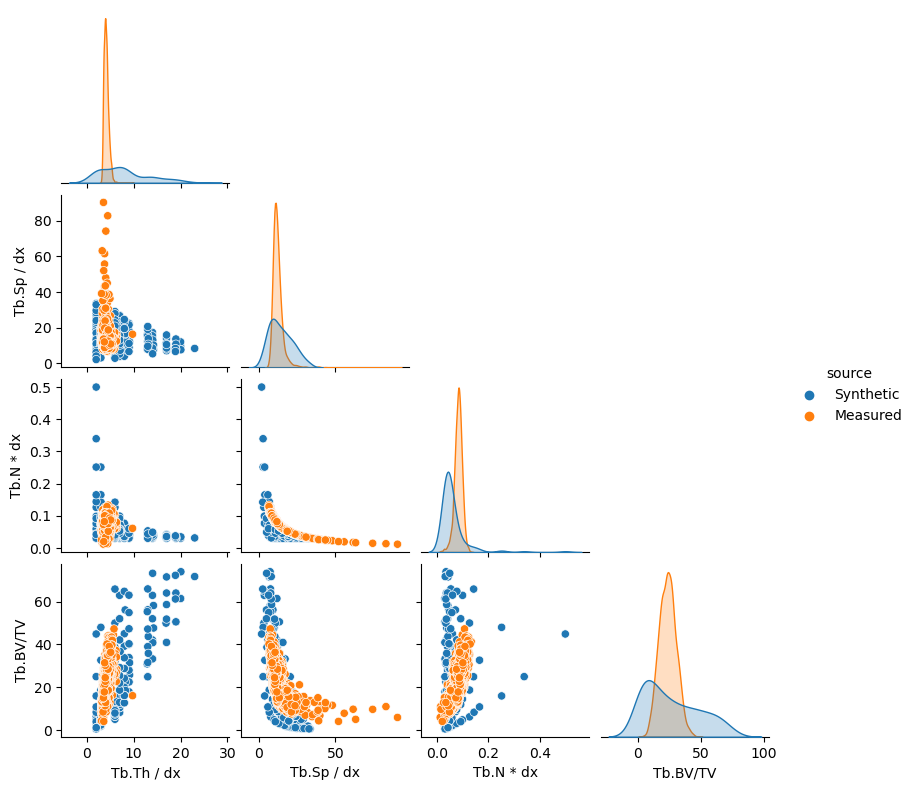

In [14]:
sns.pairplot(
    data=df[(df["source"]=="Synthetic")|(df["source"]=="Measured")][["source","Tb.Th / dx", "Tb.Sp / dx", "Tb.N * dx", "Tb.BV/TV"]], 
    hue="source", diag_kind="kde", diag_kws={"common_norm": False}, corner=True, 
    grid_kws={"diag_sharey":False}, height=2
)
plt.savefig("pairplot.png", dpi=300)
plt.show()

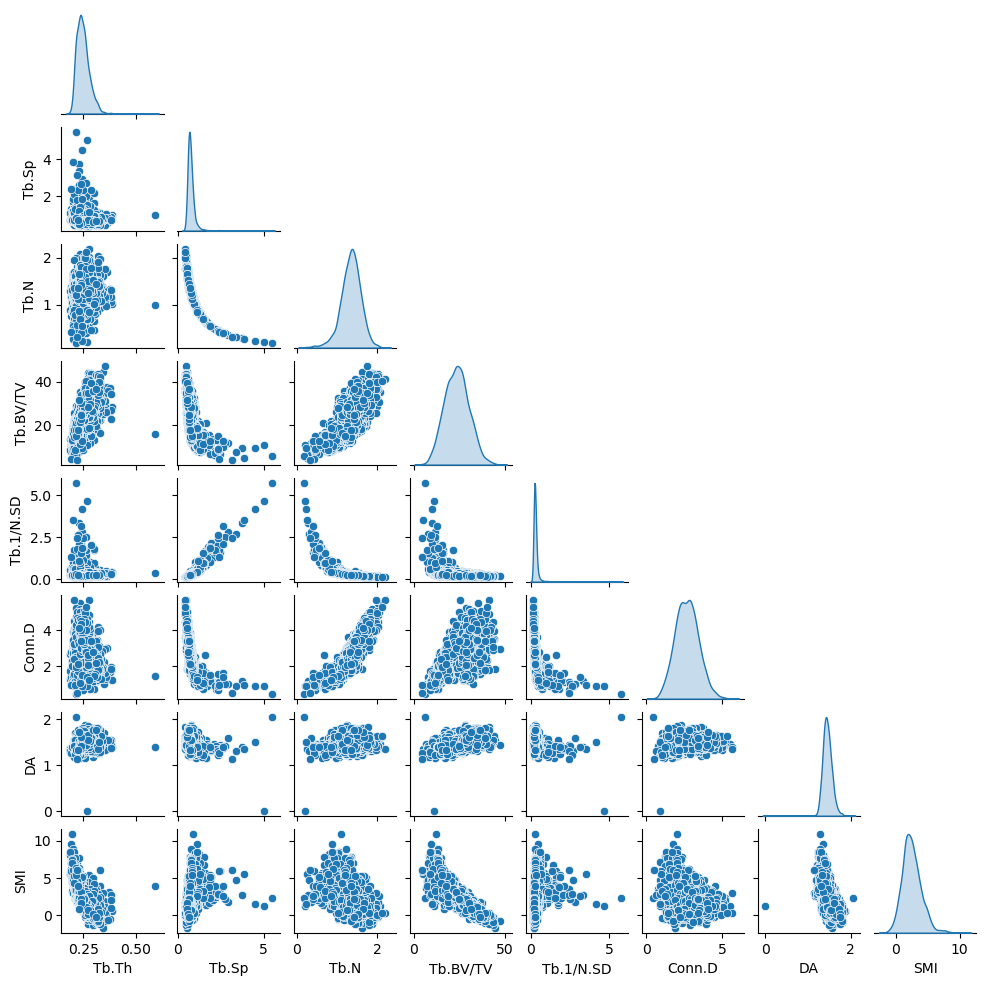

In [15]:
sns.pairplot(
    data=df[df["source"]=="Measured"][
        ["Tb.Th", "Tb.Sp", "Tb.N", "Tb.BV/TV", "Tb.1/N.SD", "Conn.D", "DA", "SMI"]
    ], 
    diag_kind="kde", diag_kws={"common_norm": False}, corner=True, 
    grid_kws={"diag_sharey":False}, height=1.25
)
plt.savefig("pairplot_other_parameters.png", dpi=300)
plt.show()

Create normalized data for use in PCA

In [16]:
sources = set(df["source"].values)
columns = [col for col in df.columns if col != "source"]
for source in sources:
    for col in columns:
        df.loc[df["source"] == source, f"{col} PCA"] = (
            (
                df[df["source"] == source][col] 
                - df[df["source"] == source][col].mean()
            ) / df[df["source"] == source][col].std()
        )

df

,Tb.BV/TV,Tb.N,Tb.Sp,Tb.Th,source,dx,Conn.D,SMI,Tb.1/N.SD,DA,...,Tb.Sp PCA,Tb.Th PCA,dx PCA,Conn.D PCA,SMI PCA,Tb.1/N.SD PCA,DA PCA,Tb.Th / dx PCA,Tb.Sp / dx PCA,Tb.N * dx PCA
0,1.960000,0.057017,17.538759,2.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN,...,0.406818,-1.144453,NaN,NaN,NaN,NaN,NaN,-1.144453,0.406818,-0.049780
1,33.280000,0.029849,17.246748,14.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN,...,0.367676,1.157848,NaN,NaN,NaN,NaN,NaN,1.157848,0.367676,-0.527245
2,25.840000,0.036945,15.167651,9.126035,Synthetic,1.0000,NaN,NaN,NaN,NaN,...,0.088983,0.222737,NaN,NaN,NaN,NaN,NaN,0.222737,0.088983,-0.402536
3,62.920000,0.043463,6.494861,14.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN,...,-1.073561,1.157848,NaN,NaN,NaN,NaN,NaN,1.157848,-1.073561,-0.287986
4,25.920000,0.075912,8.355190,6.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN,...,-0.824193,-0.377019,NaN,NaN,NaN,NaN,NaN,-0.377019,-0.824193,0.282291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,33.833263,1.494946,0.529509,0.231167,Independent,0.0607,4.0874,0.8506,0.188939,1.7229,...,-0.825709,-0.578175,0.999841,1.870139,-1.107029,-0.499824,2.566096,-0.578175,-0.825709,0.594910
9596,25.132586,1.456938,0.609297,0.296350,Independent,0.0607,2.7817,0.1693,0.264256,1.7512,...,-0.533968,1.588734,0.999841,0.152478,-1.565539,-0.221777,2.833285,1.588734,-0.533968,0.448115
9597,14.010496,1.144277,0.651621,0.308975,Independent,0.0607,2.1990,-0.2502,0.279018,1.7602,...,-0.379213,2.008433,0.999841,-0.614070,-1.847859,-0.167280,2.918256,2.008433,-0.379213,-0.759463
9598,32.337081,1.176330,0.723328,0.227161,Independent,0.0607,2.1319,3.9000,0.264900,1.3158,...,-0.117019,-0.711348,0.999841,-0.702341,0.945194,-0.219399,-1.277450,-0.711348,-0.117019,-0.635670


Generate PCA figures

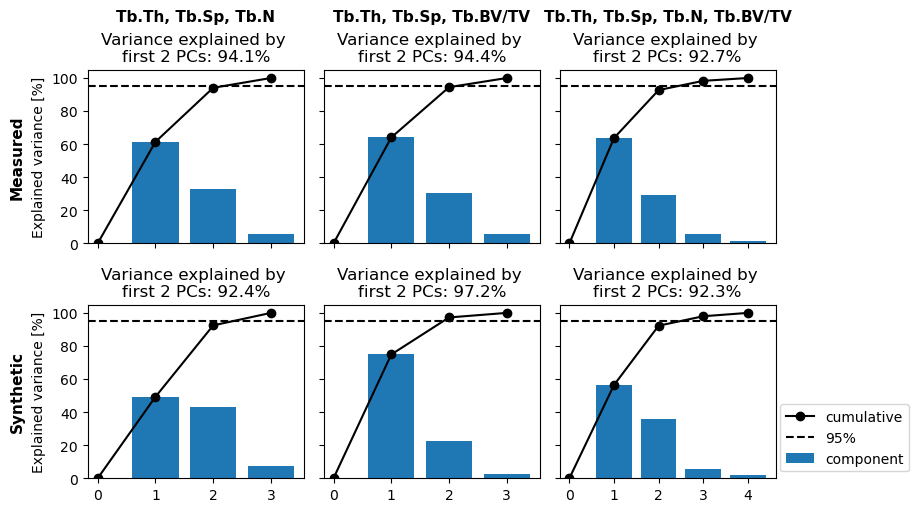

In [17]:
sources = ["Measured", "Synthetic"] #["Synthetic", "Measured", "Dependent", "Independent"]


fig, axss = plt.subplots(len(sources), 3, figsize=(9,2.5*len(sources)), sharey=True, sharex="col")


for source, axs in zip(sources, axss):
    
    pca = PCA()
    pca = pca.fit(df[df["source"]==source][["Tb.Th PCA", "Tb.Sp PCA", "Tb.N PCA"]])
    
    explained_variance_ratio = 100*pca.explained_variance_ratio_
    explained_variance_ratio_cum = np.cumsum(explained_variance_ratio)
    
    axs[0].bar([1,2,3], explained_variance_ratio)
    axs[0].plot([0] + list(explained_variance_ratio_cum), "k-o")
    axs[0].axhline(95, c="k", linestyle="--")
    axs[0].set_title(
        f"Variance explained by \nfirst 2 PCs: {explained_variance_ratio_cum[1]:0.1f}%"
    )
    axs[0].set_ylabel("Explained variance [%]")
    
    pca = PCA()
    pca = pca.fit(df[df["source"]==source][["Tb.Th PCA", "Tb.Sp PCA", "Tb.BV/TV PCA"]])
    
    explained_variance_ratio = 100*pca.explained_variance_ratio_
    explained_variance_ratio_cum = np.cumsum(explained_variance_ratio)
    
    axs[1].bar([1,2,3], explained_variance_ratio)
    axs[1].plot([0] + list(explained_variance_ratio_cum), "k-o")
    axs[1].axhline(95, c="k", linestyle="--")
    axs[1].set_title(
        f"Variance explained by \nfirst 2 PCs: {explained_variance_ratio_cum[1]:0.1f}%"
    )
    
    pca = PCA()
    pca = pca.fit(df[df["source"]==source][["Tb.Th PCA", "Tb.Sp PCA", "Tb.BV/TV PCA", "Tb.N PCA"]])
    
    explained_variance_ratio = 100*pca.explained_variance_ratio_
    explained_variance_ratio_cum = np.cumsum(explained_variance_ratio)
    
    axs[2].bar([1,2,3,4], explained_variance_ratio, label="component")
    axs[2].plot([0] + list(explained_variance_ratio_cum), "k-o", label="cumulative")
    axs[2].axhline(95, c="k", linestyle="--", label="95%")
    axs[2].set_title(
        f"Variance explained by \nfirst 2 PCs: {explained_variance_ratio_cum[1]:0.1f}%"
    )
        
    if source == "Independent":
        axs[0].set_xlabel("Principal Component #")
        axs[1].set_xlabel("Principal Component #")
        axs[2].set_xlabel("Principal Component #")


axss[-1,-1].legend(loc="lower right", bbox_to_anchor=(1.65, 0))
        
plt.tight_layout()

headers_kwargs = {"fontsize": 11, "weight": "bold"}

add_headers(
    fig,
    row_headers=sources,
    col_headers=["Tb.Th, Tb.Sp, Tb.N", "Tb.Th, Tb.Sp, Tb.BV/TV", "Tb.Th, Tb.Sp, Tb.N, Tb.BV/TV"],
    row_pad=1,
    col_pad=35,
    rotate_row_headers=True,
    **headers_kwargs
)

fig.savefig("pca.png", dpi=300, bbox_inches = "tight")
plt.show()

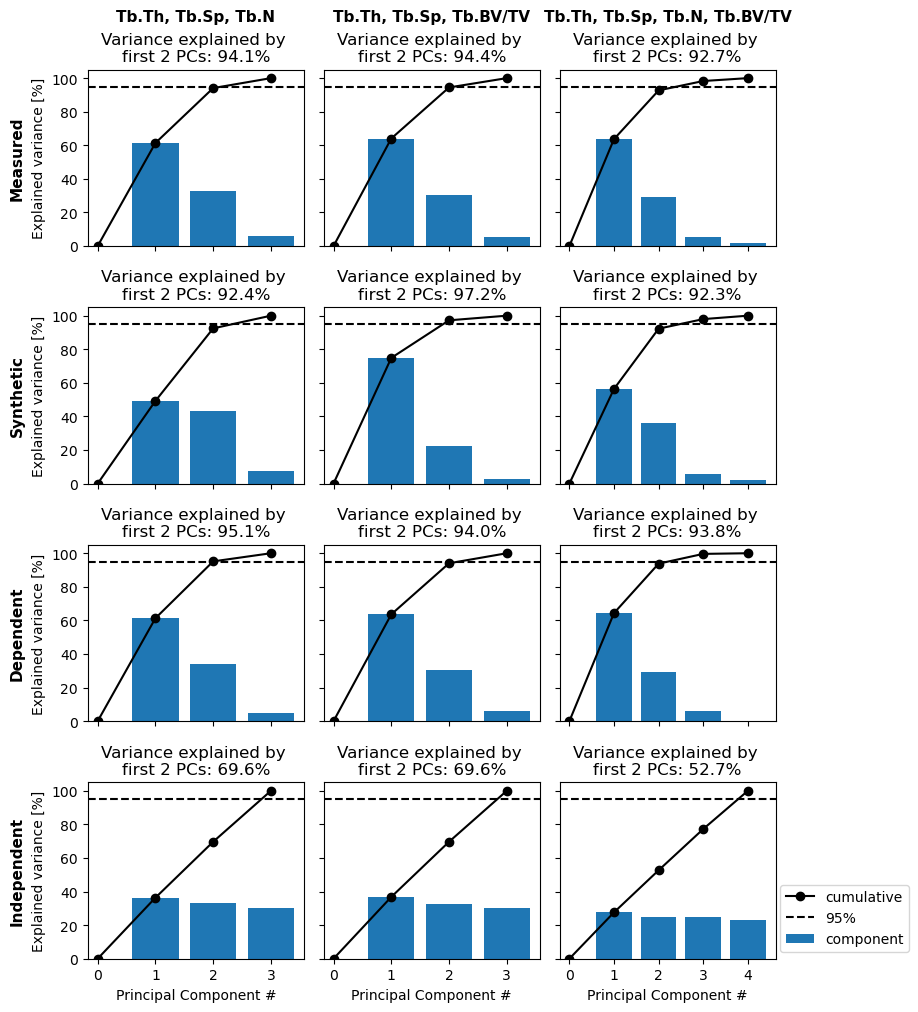

In [18]:
sources = ["Measured", "Synthetic", "Dependent", "Independent"]


fig, axss = plt.subplots(len(sources), 3, figsize=(9,2.5*len(sources)), sharey=True, sharex="col")


for source, axs in zip(sources, axss):
    
    pca = PCA()
    pca = pca.fit(df[df["source"]==source][["Tb.Th PCA", "Tb.Sp PCA", "Tb.N PCA"]])
    
    explained_variance_ratio = 100*pca.explained_variance_ratio_
    explained_variance_ratio_cum = np.cumsum(explained_variance_ratio)
    
    axs[0].bar([1,2,3], explained_variance_ratio)
    axs[0].plot([0] + list(explained_variance_ratio_cum), "k-o")
    axs[0].axhline(95, c="k", linestyle="--")
    axs[0].set_title(
        f"Variance explained by \nfirst 2 PCs: {explained_variance_ratio_cum[1]:0.1f}%"
    )
    axs[0].set_ylabel("Explained variance [%]")
    
    pca = PCA()
    pca = pca.fit(df[df["source"]==source][["Tb.Th PCA", "Tb.Sp PCA", "Tb.BV/TV PCA"]])
    
    explained_variance_ratio = 100*pca.explained_variance_ratio_
    explained_variance_ratio_cum = np.cumsum(explained_variance_ratio)
    
    axs[1].bar([1,2,3], explained_variance_ratio)
    axs[1].plot([0] + list(explained_variance_ratio_cum), "k-o")
    axs[1].axhline(95, c="k", linestyle="--")
    axs[1].set_title(
        f"Variance explained by \nfirst 2 PCs: {explained_variance_ratio_cum[1]:0.1f}%"
    )
    
    pca = PCA()
    pca = pca.fit(df[df["source"]==source][["Tb.Th PCA", "Tb.Sp PCA", "Tb.BV/TV PCA", "Tb.N PCA"]])
    
    explained_variance_ratio = 100*pca.explained_variance_ratio_
    explained_variance_ratio_cum = np.cumsum(explained_variance_ratio)
    
    axs[2].bar([1,2,3,4], explained_variance_ratio, label="component")
    axs[2].plot([0] + list(explained_variance_ratio_cum), "k-o", label="cumulative")
    axs[2].axhline(95, c="k", linestyle="--", label="95%")
    axs[2].set_title(
        f"Variance explained by \nfirst 2 PCs: {explained_variance_ratio_cum[1]:0.1f}%"
    )
        
    if source == "Independent":
        axs[0].set_xlabel("Principal Component #")
        axs[1].set_xlabel("Principal Component #")
        axs[2].set_xlabel("Principal Component #")


axss[-1,-1].legend(loc="lower right", bbox_to_anchor=(1.65, 0))
        
plt.tight_layout()

headers_kwargs = {"fontsize": 11, "weight": "bold"}

add_headers(
    fig,
    row_headers=sources,
    col_headers=["Tb.Th, Tb.Sp, Tb.N", "Tb.Th, Tb.Sp, Tb.BV/TV", "Tb.Th, Tb.Sp, Tb.N, Tb.BV/TV"],
    row_pad=1,
    col_pad=35,
    rotate_row_headers=True,
    **headers_kwargs
)

fig.savefig("pca_supplemental.png", dpi=300, bbox_inches = "tight")
plt.show()

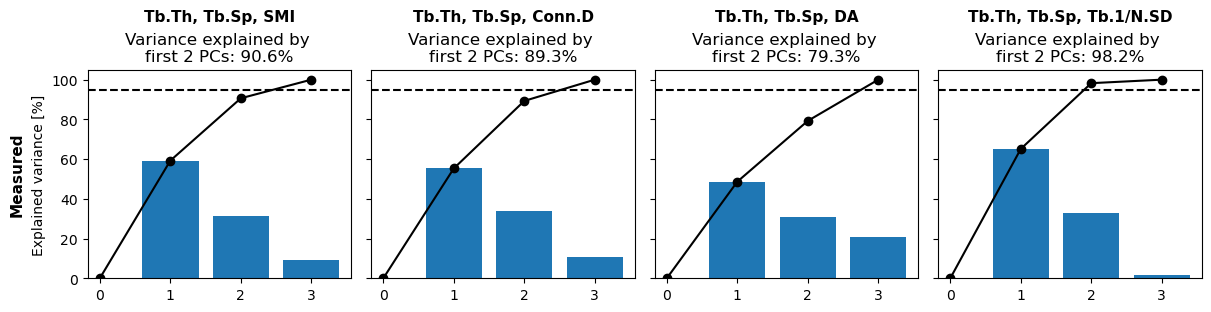

In [19]:
source = "Measured"

fig, axs = plt.subplots(1, 4, figsize=(12,3), sharey=True, sharex="col")

pca = PCA()
pca = pca.fit(df[df["source"]==source][["Tb.Th PCA", "Tb.Sp PCA", "SMI PCA"]])

explained_variance_ratio = 100*pca.explained_variance_ratio_
explained_variance_ratio_cum = np.cumsum(explained_variance_ratio)

axs[0].bar([1,2,3], explained_variance_ratio)
axs[0].plot([0] + list(explained_variance_ratio_cum), "k-o")
axs[0].axhline(95, c="k", linestyle="--")
axs[0].set_title(
    f"Variance explained by \nfirst 2 PCs: {explained_variance_ratio_cum[1]:0.1f}%"
)
axs[0].set_ylabel("Explained variance [%]")

pca = PCA()
pca = pca.fit(df[df["source"]==source][["Tb.Th PCA", "Tb.Sp PCA", "Conn.D PCA"]])

explained_variance_ratio = 100*pca.explained_variance_ratio_
explained_variance_ratio_cum = np.cumsum(explained_variance_ratio)

axs[1].bar([1,2,3], explained_variance_ratio)
axs[1].plot([0] + list(explained_variance_ratio_cum), "k-o")
axs[1].axhline(95, c="k", linestyle="--")
axs[1].set_title(
    f"Variance explained by \nfirst 2 PCs: {explained_variance_ratio_cum[1]:0.1f}%"
)

pca = PCA()
pca = pca.fit(df[df["source"]==source][["Tb.Th PCA", "Tb.Sp PCA", "DA PCA"]])

explained_variance_ratio = 100*pca.explained_variance_ratio_
explained_variance_ratio_cum = np.cumsum(explained_variance_ratio)

axs[2].bar([1,2,3], explained_variance_ratio, label="component")
axs[2].plot([0] + list(explained_variance_ratio_cum), "k-o", label="cumulative")
axs[2].axhline(95, c="k", linestyle="--", label="95%")
axs[2].set_title(
    f"Variance explained by \nfirst 2 PCs: {explained_variance_ratio_cum[1]:0.1f}%"
)


pca = PCA()
pca = pca.fit(df[df["source"]==source][["Tb.Th PCA", "Tb.Sp PCA", "Tb.1/N.SD PCA"]])

explained_variance_ratio = 100*pca.explained_variance_ratio_
explained_variance_ratio_cum = np.cumsum(explained_variance_ratio)

axs[3].bar([1,2,3], explained_variance_ratio, label="component")
axs[3].plot([0] + list(explained_variance_ratio_cum), "k-o", label="cumulative")
axs[3].axhline(95, c="k", linestyle="--", label="95%")
axs[3].set_title(
    f"Variance explained by \nfirst 2 PCs: {explained_variance_ratio_cum[1]:0.1f}%"
)

plt.tight_layout()

headers_kwargs = {"fontsize": 11, "weight": "bold"}

add_headers(
    fig,
    row_headers=["Measured"],
    col_headers=["Tb.Th, Tb.Sp, SMI", "Tb.Th, Tb.Sp, Conn.D", "Tb.Th, Tb.Sp, DA", "Tb.Th, Tb.Sp, Tb.1/N.SD"],
    row_pad=1,
    col_pad=35,
    rotate_row_headers=True,
    **headers_kwargs
)

fig.savefig("pca_other_params.png", dpi=300, bbox_inches = "tight")
plt.show()

Linear regressions

$$ \frac{1}{\text{Tb.N}} \approx \text{Tb.Th} + \text{Tb.Sp} $$

In [20]:
for source in ["Synthetic", "Measured"]:
    
    print("="*50)
    print(source)
    print("="*50)

    Y = 1 / df[df["source"]==source]["Tb.N"]
    X = df[df["source"]==source][["Tb.Th", "Tb.Sp"]]
    X = sm.add_constant(X)

    tbn_inverse_model = sm.OLS(Y,X)
    tbn_inverse_model_results = tbn_inverse_model.fit()
    display(tbn_inverse_model_results.summary())

Synthetic


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Tb.N   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     3451.
Date:                Wed, 29 Nov 2023   Prob (F-statistic):          1.77e-120
Time:                        13:40:23   Log-Likelihood:                -224.57
No. Observations:                 144   AIC:                             455.1
Df Residuals:                     141   BIC:                             464.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0037      0.308     -6.498      0.000      -2.613      -1.394
Tb.Th          1.2368      0.020     62.573      0.000       1.198       1.276
Tb.Sp          0.9975      0.014     72.230      0.000       0.970       1.025
==============================================================================
Omnibus:                        7.990   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.410
Skew:                           0.587   Prob(JB):                       0.0149
Kurtosis:                       2.853   Cond. No.                         56.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Measured


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Tb.N   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 2.747e+05
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:40:23   Log-Likelihood:                 8018.9
No. Observations:                3152   AIC:                        -1.603e+04
Df Residuals:                    3149   BIC:                        -1.601e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0775      0.003     25.321      0.000       0.071       0.083
Tb.Th          0.0611      0.011      5.408      0.000       0.039       0.083
Tb.Sp          0.9186      0.001    738.693      0.000       0.916       0.921
==============================================================================
Omnibus:                      504.283   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2511.110
Skew:                           0.675   Prob(JB):                         0.00
Kurtosis:                       7.159   Cond. No.                         44.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Create some additional entries in the dataframe for testing the upcoming power-law relationships

In [21]:
df["ln(Tb.BV/TV)"] = np.log(df["Tb.BV/TV"]/100)
df["ln(Tb.Th/(Tb.Th+Tb.Sp))"] = np.log(df["Tb.Th"]/(df["Tb.Th"]+df["Tb.Sp"]))
df

,Tb.BV/TV,Tb.N,Tb.Sp,Tb.Th,source,dx,Conn.D,SMI,Tb.1/N.SD,DA,...,dx PCA,Conn.D PCA,SMI PCA,Tb.1/N.SD PCA,DA PCA,Tb.Th / dx PCA,Tb.Sp / dx PCA,Tb.N * dx PCA,ln(Tb.BV/TV),ln(Tb.Th/(Tb.Th+Tb.Sp))
0,1.960000,0.057017,17.538759,2.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.144453,0.406818,-0.049780,-3.932226,-2.279253
1,33.280000,0.029849,17.246748,14.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.157848,0.367676,-0.527245,-1.100214,-0.802858
2,25.840000,0.036945,15.167651,9.126035,Synthetic,1.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.222737,0.088983,-0.402536,-1.353247,-0.979085
3,62.920000,0.043463,6.494861,14.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.157848,-1.073561,-0.287986,-0.463306,-0.381117
4,25.920000,0.075912,8.355190,6.000000,Synthetic,1.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.377019,-0.824193,0.282291,-1.350155,-0.872352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,33.833263,1.494946,0.529509,0.231167,Independent,0.0607,4.0874,0.8506,0.188939,1.7229,...,0.999841,1.870139,-1.107029,-0.499824,2.566096,-0.578175,-0.825709,0.594910,-1.083726,-1.191067
9596,25.132586,1.456938,0.609297,0.296350,Independent,0.0607,2.7817,0.1693,0.264256,1.7512,...,0.999841,0.152478,-1.565539,-0.221777,2.833285,1.588734,-0.533968,0.448115,-1.381005,-1.117108
9597,14.010496,1.144277,0.651621,0.308975,Independent,0.0607,2.1990,-0.2502,0.279018,1.7602,...,0.999841,-0.614070,-1.847859,-0.167280,2.918256,2.008433,-0.379213,-0.759463,-1.965363,-1.134294
9598,32.337081,1.176330,0.723328,0.227161,Independent,0.0607,2.1319,3.9000,0.264900,1.3158,...,0.999841,-0.702341,0.945194,-0.219399,-1.277450,-0.711348,-0.117019,-0.635670,-1.128956,-1.431318


$$ \text{Tb.BV/TV} \approx A \left( \frac{\text{Tb.Th}}{\text{Tb.Th} + \text{Tb.Sp}} \right)^\alpha $$

In [22]:
for source in ["Synthetic", "Measured"]:
    
    print("="*50)
    print(source)
    print("="*50)

    Y = df[df["source"]==source]["ln(Tb.BV/TV)"]
    X = df[df["source"]==source]["ln(Tb.Th/(Tb.Th+Tb.Sp))"]
    X = sm.add_constant(X)

    tbbvtv_log_model = sm.OLS(Y,X)
    tbbvtv_log_model_results = tbbvtv_log_model.fit()
    display(tbbvtv_log_model_results.summary())

    A = tbbvtv_log_model_results.params["const"]
    A_se = tbbvtv_log_model_results.bse["const"]
    alpha = tbbvtv_log_model_results.params["ln(Tb.Th/(Tb.Th+Tb.Sp))"]
    alpha_se = tbbvtv_log_model_results.bse["ln(Tb.Th/(Tb.Th+Tb.Sp))"]
    print(f"ln(A) = {A:0.3f} (SE {A_se:0.3f}) => A ~~ {np.exp(A):0.3f}")
    print(f"alpha = {alpha:0.3f} (SE {alpha_se:0.3f})")
    print("")
    
print(f"NOTE: pi/2 ~~ {(np.pi/2):0.3f}, ln(pi/2) ~~ {np.log(np.pi/2):0.3f}")

Synthetic


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ln(Tb.BV/TV)   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.469e+04
Date:                Wed, 29 Nov 2023   Prob (F-statistic):          3.00e-145
Time:                        13:40:23   Log-Likelihood:                 99.619
No. Observations:                 144   AIC:                            -195.2
Df Residuals:                     142   BIC:                            -189.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.3128      0.021     15.241      0.000       0.272       0.353
ln(Tb.Th/(Tb.Th+Tb.Sp))     1.8054      0.015    121.216      0.000       1.776       1.835
==============================================================================
Omnibus:                       16.385   Durbin-Watson:                   1.602
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.198
Skew:                           0.320   Prob(JB):                       0.0274
Kurtosis:                       2.111   Cond. No.                         4.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ln(A) = 0.313 (SE 0.021) => A ~~ 1.367
alpha = 1.805 (SE 0.015)

Measured


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ln(Tb.BV/TV)   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                 1.510e+04
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:40:23   Log-Likelihood:                 1996.1
No. Observations:                3152   AIC:                            -3988.
Df Residuals:                    3150   BIC:                            -3976.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.2622      0.014     18.101      0.000       0.234       0.291
ln(Tb.Th/(Tb.Th+Tb.Sp))     1.2732      0.010    122.872      0.000       1.253       1.294
==============================================================================
Omnibus:                     1110.569   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17439.424
Skew:                           1.242   Prob(JB):                         0.00
Kurtosis:                      14.252   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ln(A) = 0.262 (SE 0.014) => A ~~ 1.300
alpha = 1.273 (SE 0.010)

NOTE: pi/2 ~~ 1.571, ln(pi/2) ~~ 0.452


How many of each kind of image in each subset of the in vivo dataset?

In [23]:
num_radii = df_normxtii["Filename"].apply(lambda x: x[:-1].endswith("R")).sum()
num_tibae = df_normxtii["Filename"].apply(lambda x: x[:-1].endswith("T")).sum()

print(f"In NORMXTII, {num_radii} radii and {num_tibae} tibiae")

num_radii = df_hipfx["Filename"].apply(lambda x: x[:-1].endswith("R")).sum()
num_tibae = df_hipfx["Filename"].apply(lambda x: x[:-1].endswith("T")).sum()

print(f"In HIPFX,    {num_radii} radii and {num_tibae} tibiae")

num_radii = df_csi["Filename"].apply(lambda x: x[:-5].endswith("R")).sum()
num_tibae = df_csi["Filename"].apply(lambda x: x[:-5].endswith("T")).sum()

print(f"In CSI,      {num_radii} radii and {num_tibae} tibiae")

num_radii = df_fsk["Filename"].apply(lambda x: x[:-5].endswith("R")).sum()
num_tibae = df_fsk["Filename"].apply(lambda x: x[:-5].endswith("T")).sum()

print(f"In FSK,      {num_radii} radii and {num_tibae} tibiae")

In NORMXTII, 1243 radii and 1245 tibiae
In HIPFX,    109 radii and 176 tibiae
In CSI,      103 radii and 111 tibiae
In FSK,      56 radii and 109 tibiae


What are the means and SDs of normalized trabecular thickness in the synthetic and in vivo datasets?

In [24]:
print(
    df[df["source"]=="Measured"]["Tb.Th / dx"].mean(),
    df[df["source"]=="Measured"]["Tb.Th / dx"].std()
)

4.094878715117203 0.49556992813685274


In [25]:
print(
    df[df["source"]=="Synthetic"]["Tb.Th / dx"].mean(),
    df[df["source"]=="Synthetic"]["Tb.Th / dx"].std()
)

7.965091868055556 5.212177099060809
